In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt

import torch.optim as optim
import torch.nn as nn

from qibo import Circuit, gates, hamiltonians, set_backend, construct_backend

from qiboml.models.encoding import PhaseEncoding
from qiboml.models.decoding import Expectation
from qiboml.interfaces.pytorch import QuantumModel
from qiboml.operations.differentiation import PSR, Jax

In [3]:
def integrand_function(x):
    return x**2 + torch.sin(6 * x)

def integral_function(x):
    return x**3/3 - torch.cos(6 * x)/6.

In [4]:
x = torch.linspace(0, 1, 100)
g = integrand_function(x)
I = integral_function(x)

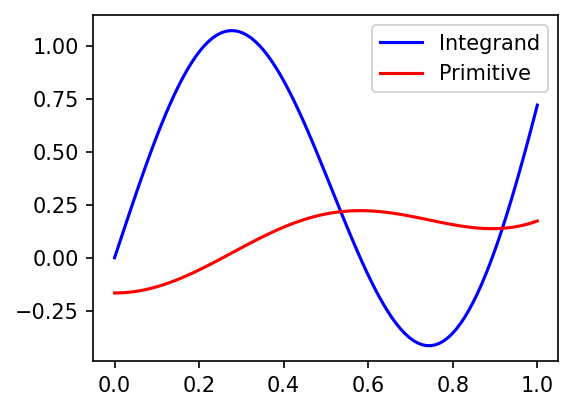

In [5]:
plt.figure(figsize=(4, 3), dpi=150)
plt.plot(x, g, label="Integrand", c="blue")
plt.plot(x, I, label="Primitive", c="red")
plt.legend()
plt.show()

In [10]:
for epoch in range(100):
    optimizer.zero_grad()

    # Forward pass
    y_pred = torch.stack([model(x) for x in x_train]).squeeze(-1)

    # Compute derivative of y_pred with respect to x_train.
    grad_outputs = torch.ones_like(y_pred)
    dydx = torch.autograd.grad(
        outputs=y_pred,
        inputs=x_train,
        grad_outputs=grad_outputs,
        create_graph=True,
        retain_graph=True,  # Keep the graph for further differentiation.
        only_inputs=True,
        allow_unused=True,
    )[0]

    # Compute the loss comparing the derivative (dydx) to your target y_train.
    loss = criterion(dydx, y_train)

    # Backward pass while retaining the graph so the derivative remains accessible.
    loss.backward(retain_graph=True)
    optimizer.step()

    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item()}")


AttributeError: 'NoneType' object has no attribute 'size'

In [36]:
predictions = torch.stack([model(x) for x in x_train])
y_pred = y_pred.squeeze(-1)

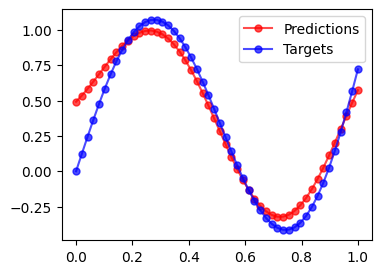

In [37]:
plt.figure(figsize=(4, 4 * 6 / 8), dpi=100)
plt.plot(
    x_train, 
    y_pred.detach().numpy(), 
    marker=".",
    markersize=10,
    color="red", 
    label="Predictions",
    alpha=0.7
)
plt.plot(
    x_train, 
    y_train,
    marker=".",
    markersize=10,
    color="blue", 
    label="Targets",
    alpha=0.7
)
plt.legend()
plt.show()